# Importing Data

## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Setting URLs and creating DataFrames

In [ ]:
url_1 = "https://raw.githubusercontent.com/thais-menezes/monitoring/main/checkout_1.csv"
url_2 = "https://raw.githubusercontent.com/thais-menezes/monitoring/main/checkout_2.csv"

In [ ]:
df_1 = pd.read_csv(url_1)
df_2 = pd.read_csv(url_2)

In [ ]:
df_1.head()

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00h,9,12,11,6.42,4.85
1,01h,3,5,1,1.85,1.92
2,02h,1,0,0,0.28,0.82
3,03h,1,0,0,0.42,0.46
4,04h,0,0,1,0.42,0.21


In [ ]:
df_2.head()

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00h,6,9,5,5.00,4.92
1,01h,3,3,2,2.00,1.92
2,02h,3,1,2,0.42,0.75
3,03h,0,1,1,0.42,0.46
4,04h,0,0,0,0.14,0.21


# Graphic and Visual Method

## Preparing data for Graphics

In [ ]:
# Categoring date (column 'time')
df_1['time'] = pd.Categorical(df_1['time'], categories=[f'{str(i).zfill(2)}h' for i in range(24)], ordered=True)
df_2['time'] = pd.Categorical(df_2['time'], categories=[f'{str(i).zfill(2)}h' for i in range(24)], ordered=True)
columns_to_compare = ['today', 'yesterday', 'same_day_last_week', 'avg_last_week', 'avg_last_month']

## Plotting No-Modification Graphics

In [ ]:
# Plotting No-Modification Graphic
def plot_graphic(df):
  plt.figure(figsize=(14, 6))
  for col in columns_to_compare:
      plt.plot(df['time'], df[col], label=col, marker='o')

  plt.title("Comparison Checkout")
  plt.xlabel("Hour")
  plt.ylabel("Sales")
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

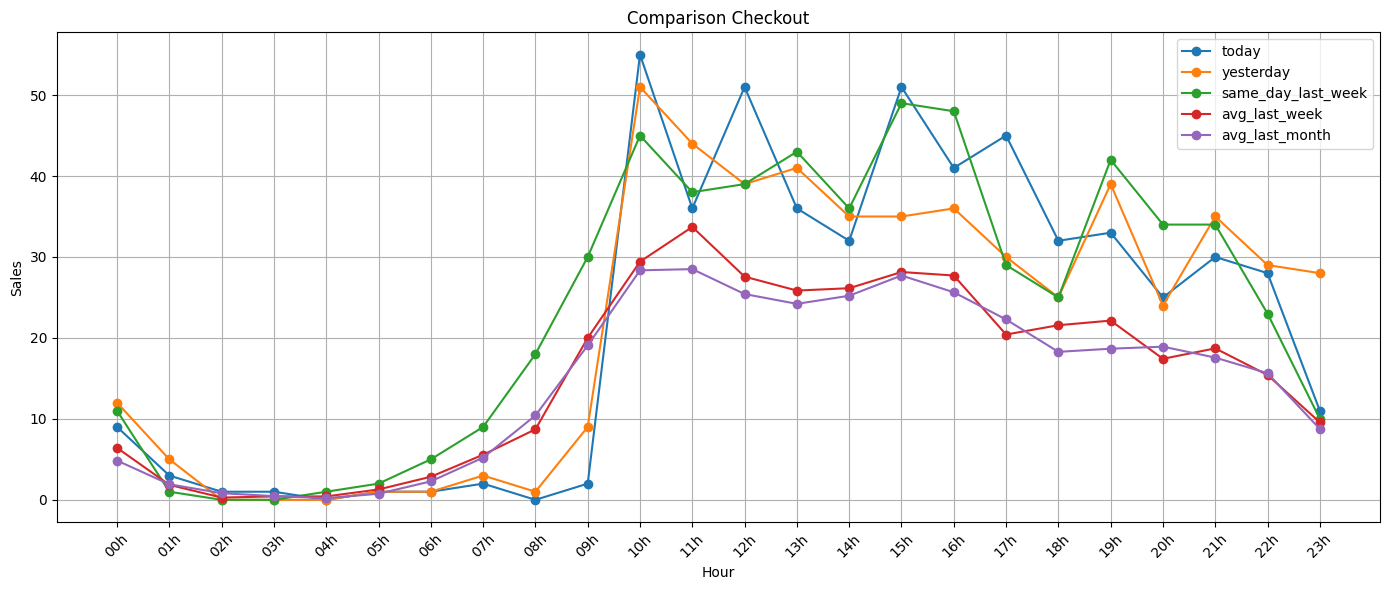

In [ ]:
plot_graphic(df_1)

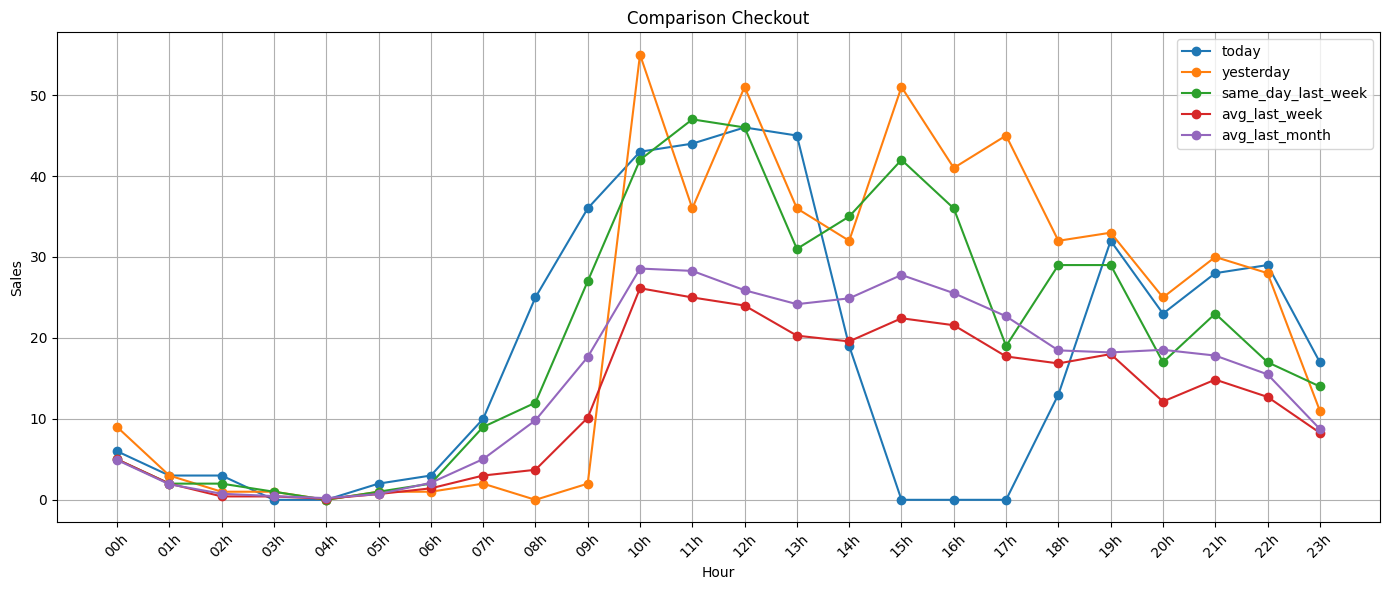

In [ ]:
plot_graphic(df_2)

## Plotting Graphics with Average

In [ ]:
# Creating Average
df_1_avg = df_1.copy()
df_2_avg = df_2.copy()
df_1_avg['avg_today_yesterday'] = df_1[['today', 'yesterday']].mean(axis=1)
df_2_avg['avg_today_yesterday'] = df_2[['today', 'yesterday']].mean(axis=1)
columns_to_compare_avg = ['avg_today_yesterday', 'same_day_last_week', 'avg_last_week', 'avg_last_month']

In [ ]:
# Plotting Graphic with Average
def plot_graphic_avg(df):
  plt.figure(figsize=(14, 6))
  for col in columns_to_compare_avg:
      plt.plot(df['time'], df[col], label=col, marker='o')

  plt.title("Comparison Checkout (With Average)")
  plt.xlabel("Hour")
  plt.ylabel("Sales")
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

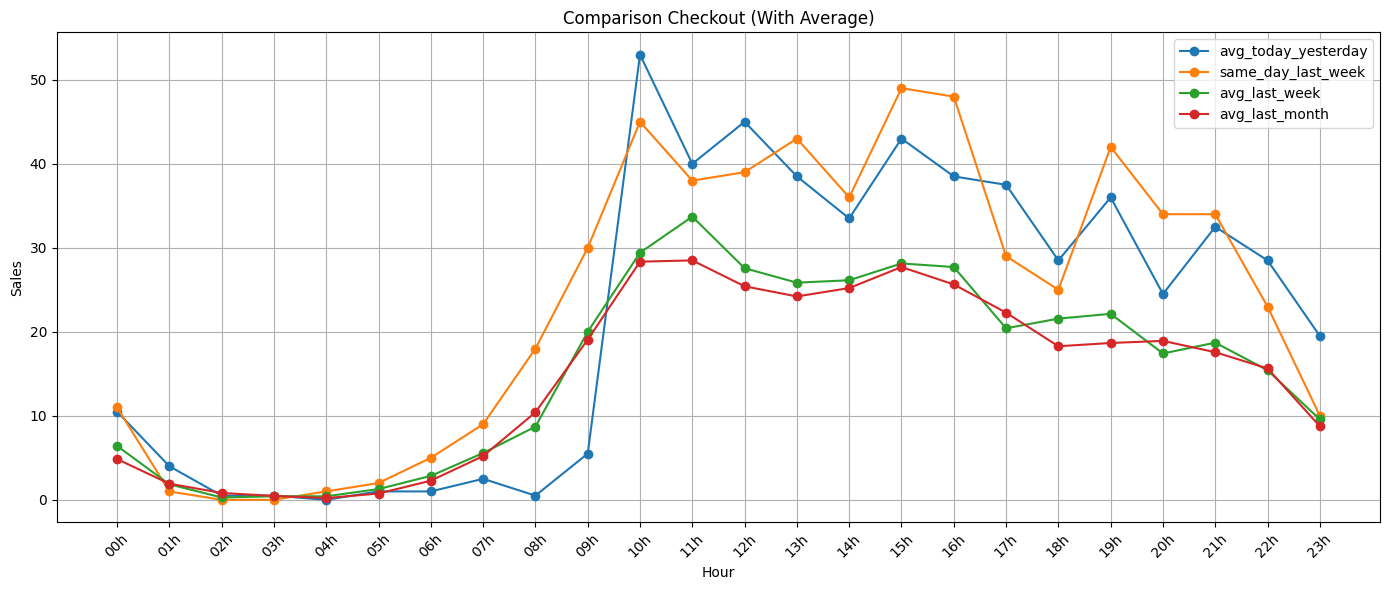

In [ ]:
plot_graphic_avg(df_1_avg)

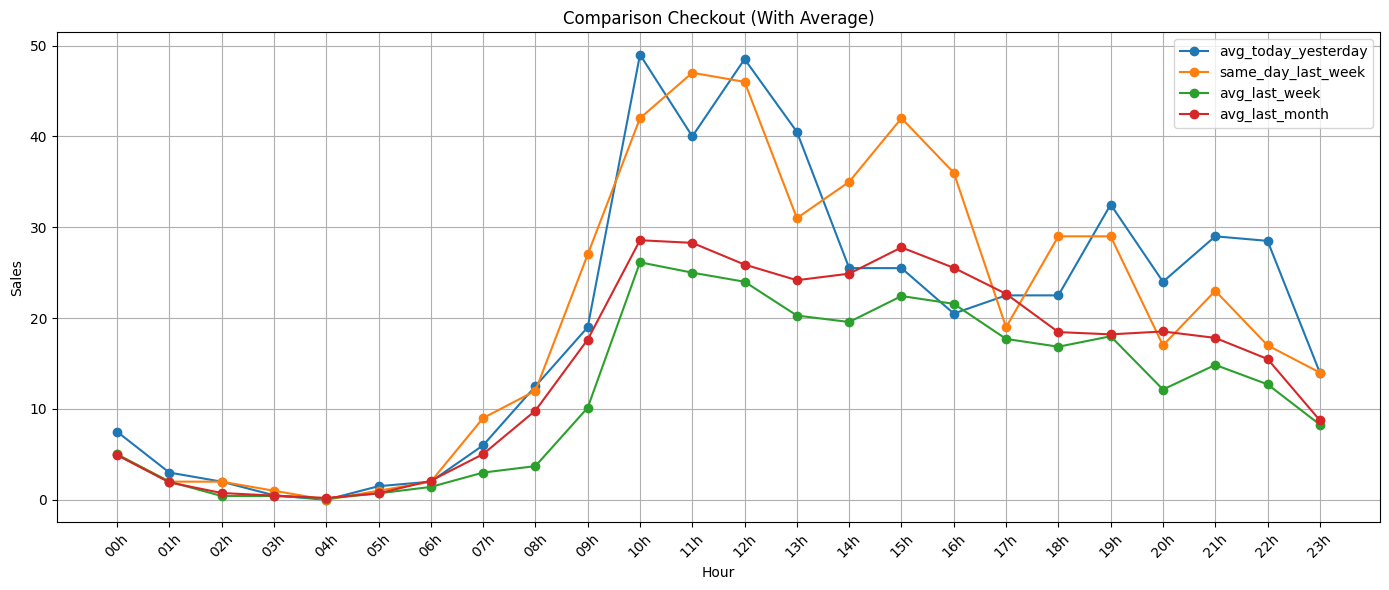

In [ ]:
plot_graphic_avg(df_2_avg)

# IQR and Quartile Methods (Idetifying Outlier)

In [ ]:
# Plotting Boxplot
def plot_boxplot(df):
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df[columns_to_compare])
  plt.title("Boxplot Checkout")
  plt.ylabel("Sales Number")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
# Applying Q3 and Q4 with IQR to Identify Outlliers
def identify_outliers(df, column):
  outliers_dict = {}

  for col in columns_to_compare:
      Q1 = df[col].quantile(0.25)
      Q3 = df[col].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
      outliers_dict[col] = outliers[['time', col]]

  return outliers_dict[column]

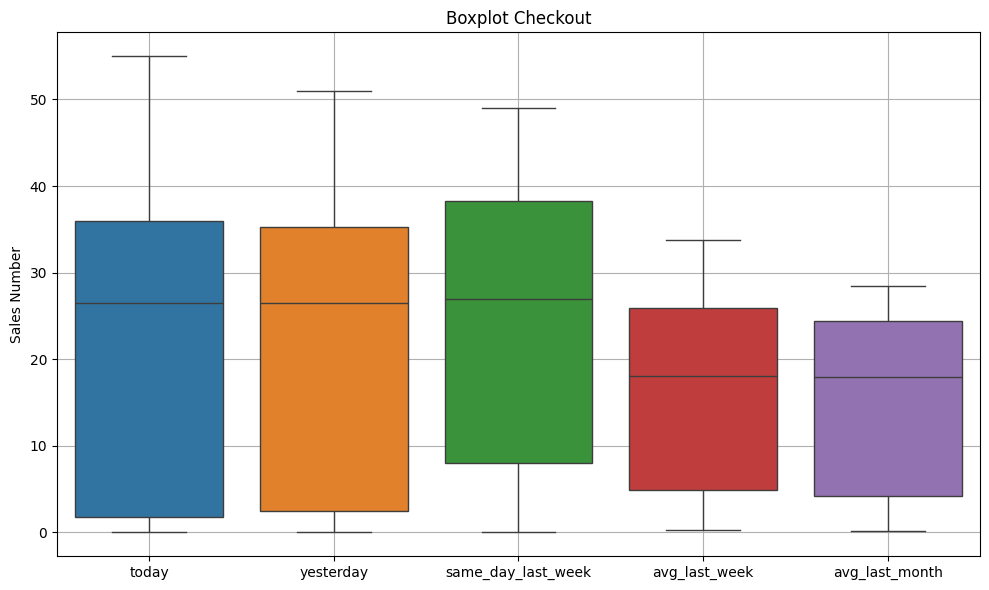

In [ ]:
plot_boxplot(df_1)

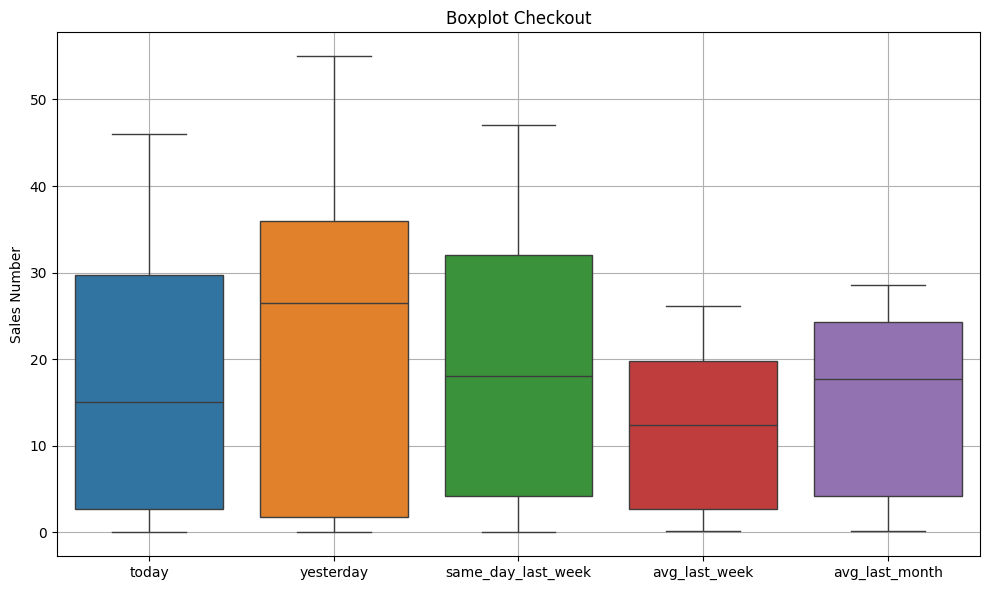

In [ ]:
plot_boxplot(df_2)

In [ ]:
identify_outliers(df_1, 'today')

,time,today


In [ ]:
identify_outliers(df_2, 'today')

,time,today


# Z-score Method

In [ ]:
# Calculating Z-score
def z_score_plot(df, column):
  # Calculating Mean, Standard Deviation
  mean = df[column].mean()
  td = df[column].std()
  df['z_score'] = (df[column] - mean) / td

  # Identify Outliers
  df['outlier'] = df['z_score'].apply(lambda z: 'Outlier' if abs(z) > 2 else 'Normal')

  # Plotting Z-score
  plt.figure(figsize=(14, 6))
  sns.scatterplot(x='time', y='z_score', hue='outlier', data=df, palette={'Outlier': 'red', 'Normal': 'blue'}, s=100)
  plt.axhline(2, color='red', linestyle='--', label='Upper Limit (Z=2)')
  plt.axhline(-2, color='red', linestyle='--', label='Lower Limit (Z=-2)')
  plt.title('Sales Z-score')
  plt.xlabel('Hours')
  plt.ylabel('Z-score')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

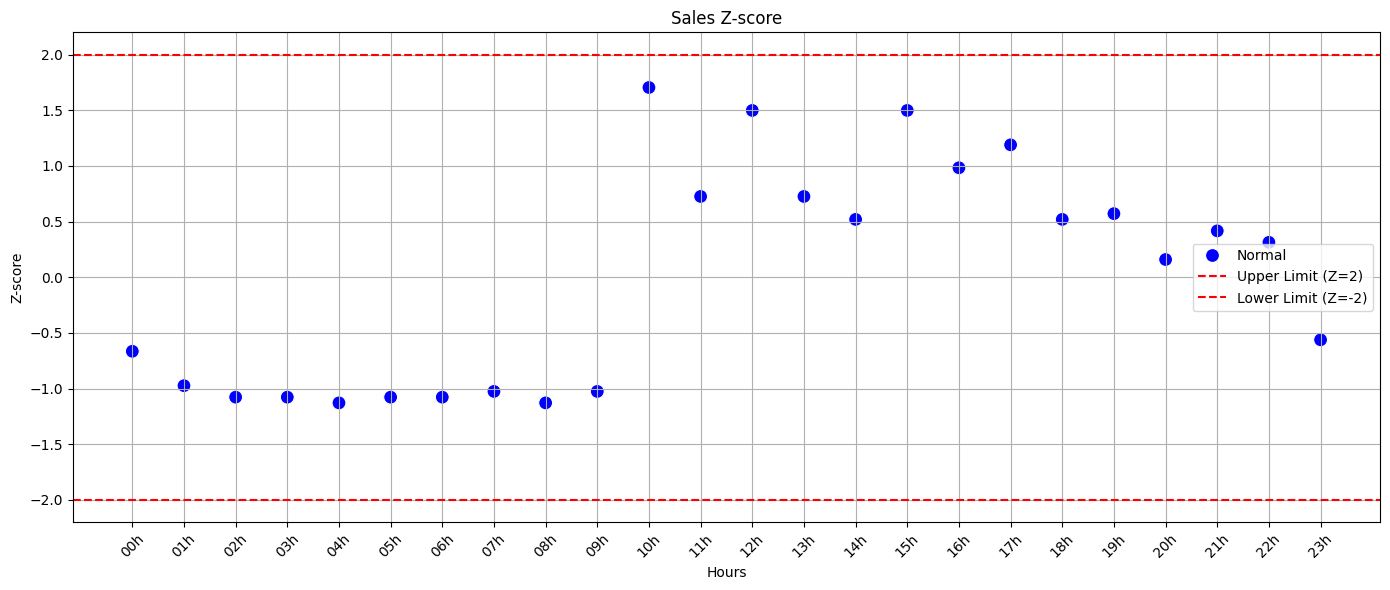

In [ ]:
z_score_plot(df_1, 'today')

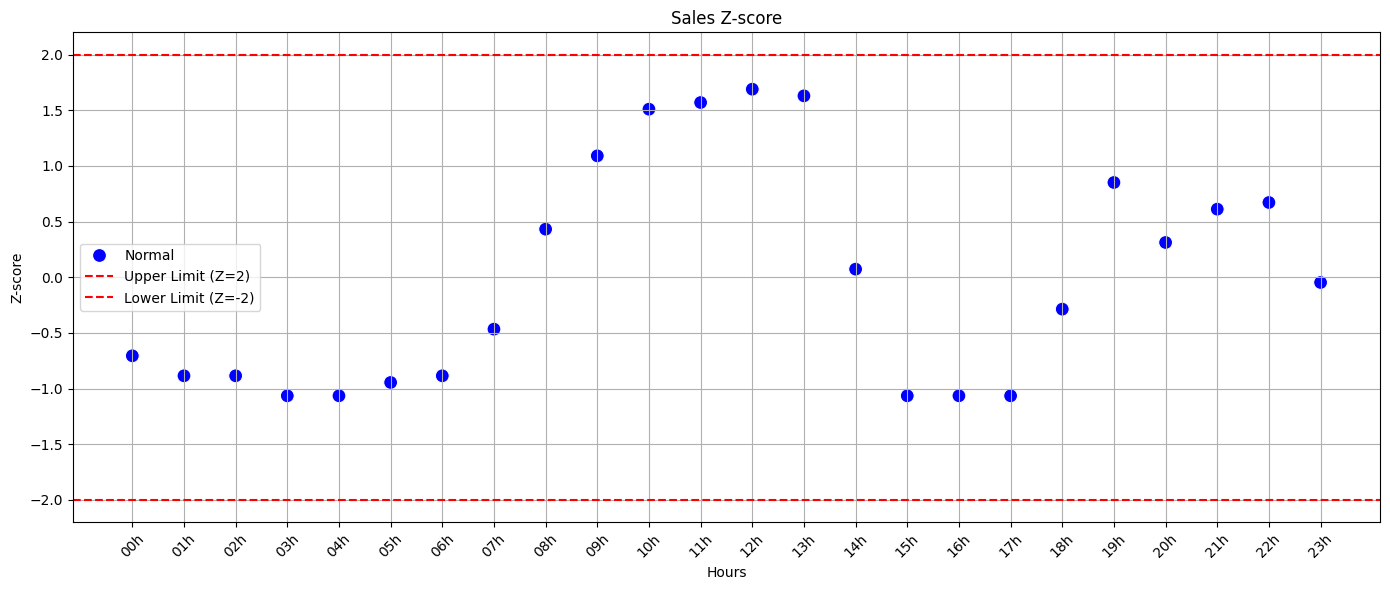

In [ ]:
z_score_plot(df_2, 'today')

# SQL Query

## Calculating using IQR and Quartiles

In [ ]:
def sql_iqr(df, column):
  # Connecting and Importing the data to the DB
  conn = sqlite3.connect(":memory:")
  df.to_sql("checkout_data", conn, index=False)

  # Calculating Q1, Q3, IQR and possible Outliers
  Q1 = df['avg_last_week'].quantile(0.25)
  Q3 = df['avg_last_week'].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  # Creating Query
  # Explanation: With 2 columns from DB (today and avg_las_week respectively) classify each case with possible Outliers value (used above).
  query = f"""
  SELECT
    time,
    {column},
    avg_last_week,
    ROUND(ABS({column} - avg_last_week) / CASE WHEN avg_last_week = 0 THEN 1 ELSE avg_last_week END, 2) AS relative_error,
    CASE
      WHEN avg_last_week < {lower} OR avg_last_week > {upper} THEN 'Outlier IQR'
      WHEN ABS({column} - avg_last_week) / CASE WHEN avg_last_week = 0 THEN 1 ELSE avg_last_week END > 0.5 THEN 'Relative Error High'
      ELSE 'Relative Error Normal'
    END AS behavior
  FROM checkout_data
  """

  # Showing the Results
  result = pd.read_sql_query(query, conn)
  return result.head(24)

In [ ]:
sql_iqr(df_1, 'today')

,time,today,avg_last_week,relative_error,behavior
0,00h,9,6.42,0.40,Relative Error Normal
1,01h,3,1.85,0.62,Relative Error High
2,02h,1,0.28,2.57,Relative Error High
3,03h,1,0.42,1.38,Relative Error High
4,04h,0,0.42,1.00,Relative Error High
5,05h,1,1.28,0.22,Relative Error Normal
6,06h,1,2.85,0.65,Relative Error High
7,07h,2,5.57,0.64,Relative Error High
8,08h,0,8.71,1.00,Relative Error High
9,09h,2,20.00,0.90,Relative Error High


In [ ]:
sql_iqr(df_2, 'today')

,time,today,avg_last_week,relative_error,behavior
0,00h,6,5.000,0.20,Relative Error Normal
1,01h,3,2.000,0.50,Relative Error Normal
2,02h,3,0.420,6.14,Relative Error High
3,03h,0,0.420,1.00,Relative Error High
4,04h,0,0.140,1.00,Relative Error High
5,05h,2,0.710,1.82,Relative Error High
6,06h,3,1.420,1.11,Relative Error High
7,07h,10,3.000,2.33,Relative Error High
8,08h,25,3.710,5.74,Relative Error High
9,09h,36,10.140,2.55,Relative Error High


## Calculating using Z-score method

In [ ]:
def sql_z(df, column):
  # Calculating the Mean and the Standard Deviation
  mean_avg = df['avg_last_week'].mean()
  std_avg = df['avg_last_week'].std()

  # Connecting and Importing the data to the DB
  conn = sqlite3.connect(":memory:")
  df.to_sql("checkout_data", conn, index=False)

  # Creating query
  # Explanation: Using the Mean and the Standard Deviation, calculate the Z-score and classify the data
  query = f"""
  SELECT
    time,
    {column},
    avg_last_week,
    ROUND((avg_last_week - {mean_avg}) / {std_avg}, 2) AS z_score,
    CASE
      WHEN ABS((avg_last_week - {mean_avg}) / {std_avg}) > 2 THEN 'Outlier Z-score'
      WHEN ABS({column} - avg_last_week) / CASE WHEN avg_last_week = 0 THEN 1 ELSE avg_last_week END > 0.5 THEN 'Relative Error High'
      ELSE 'Relative Error Normal'
    END AS behavior
  FROM checkout_data
  """

  # Showing the Results
  result = pd.read_sql_query(query, conn)
  return result.head(24)

In [ ]:
sql_z(df_1, 'today')

,time,today,avg_last_week,z_score,behavior
0,00h,9,6.42,-0.82,Relative Error Normal
1,01h,3,1.85,-1.23,Relative Error High
2,02h,1,0.28,-1.37,Relative Error High
3,03h,1,0.42,-1.36,Relative Error High
4,04h,0,0.42,-1.36,Relative Error High
5,05h,1,1.28,-1.28,Relative Error Normal
6,06h,1,2.85,-1.14,Relative Error High
7,07h,2,5.57,-0.89,Relative Error High
8,08h,0,8.71,-0.61,Relative Error High
9,09h,2,20.00,0.41,Relative Error High


In [ ]:
sql_z(df_2, 'today')

,time,today,avg_last_week,z_score,behavior
0,00h,6,5.000,-0.76,Relative Error Normal
1,01h,3,2.000,-1.09,Relative Error Normal
2,02h,3,0.420,-1.27,Relative Error High
3,03h,0,0.420,-1.27,Relative Error High
4,04h,0,0.140,-1.30,Relative Error High
5,05h,2,0.710,-1.23,Relative Error High
6,06h,3,1.420,-1.16,Relative Error High
7,07h,10,3.000,-0.98,Relative Error High
8,08h,25,3.710,-0.90,Relative Error High
9,09h,36,10.140,-0.20,Relative Error High
